In [1]:
# parameters
n_slope = 5000
n_burnin = 50000 # why not
n_analyze = 10000000 #10,000,000. Unreasonably high
n_steps = n_slope + n_burnin + n_analyze # ising.py takes this as an arg instead of n_slope
N = 100 # 100x100 lattice
b_top = 0.5 # B annealing from .5 to break symmetry at low temperatures

# Checking around Tc
t_min = 1.9
t_step = .1
t_max = 3.2

multiprocess = False # my time series code doesn't work with multiprocess yet

# run simulation (takes about 2.5 minutes per million samples)
# NOTE: this puts data in temporary directories (here, 'snapshots', 'data', and 'series'). Should be moved IMMEDIATELY
# (shell commands to move the data are in the next two cells)



In [ ]:
# !python ising.py n_steps:$n_steps n_burnin:$n_burnin n_analyze:$n_analyze N:$N b_top:$b_top t_min:$t_min t_max:$t_max \
#                  t_step:$t_step multiprocess:$multiprocess

# Experiment_name = "10M_Multitemp"
# !mkdir datatests/$Experiment_name 
# !mv data datatests/$Experiment_name
# !mv snapshots datatests/$Experiment_name
# !mv series datatests/$Experiment_name
# !mkdir data
# !mkdir snapshots
# !mkdir series

In [2]:
import numpy as np
import matplotlib.pyplot as plt

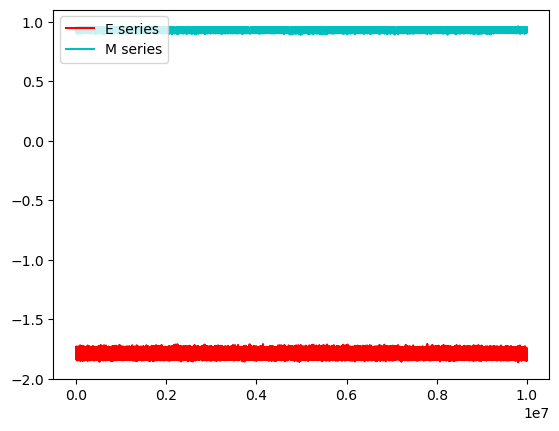

In [3]:
experiment_name = "10M_Multitemp"

# get just the data after annealing
long_E = np.load(f"datatests/{experiment_name}/series/E_series.npy")[0][n_burnin+n_slope:]
long_M = np.load(f"datatests/{experiment_name}/series/M_series.npy")[0][n_burnin+n_slope:]
plt.plot(long_E, label='E series', c='r')
plt.plot(long_M, label='M series', c='c')
plt.legend(loc='upper left')
plt.show()

In [7]:
# General things
E = np.load(f"datatests/{experiment_name}/series/E_series.npy")
M = np.load(f"datatests/{experiment_name}/series/M_series.npy")
temps = E[:, 0] # make temp array

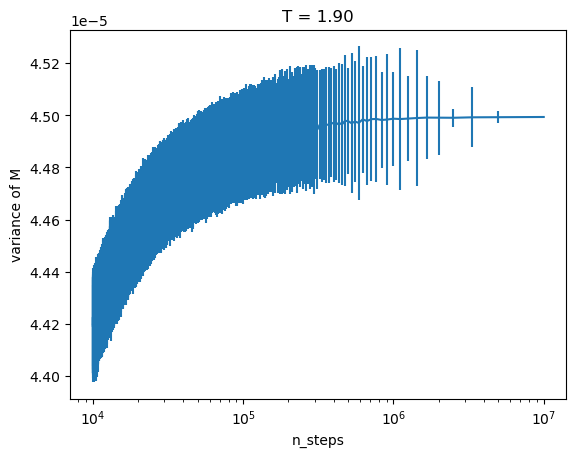

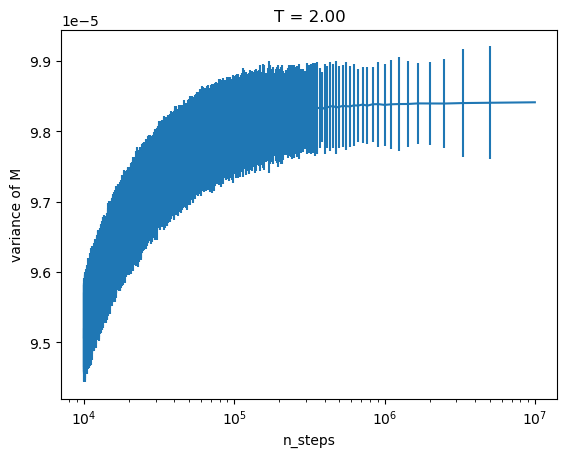

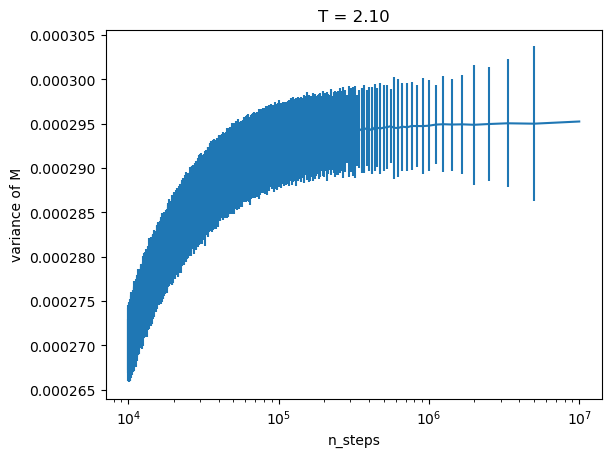

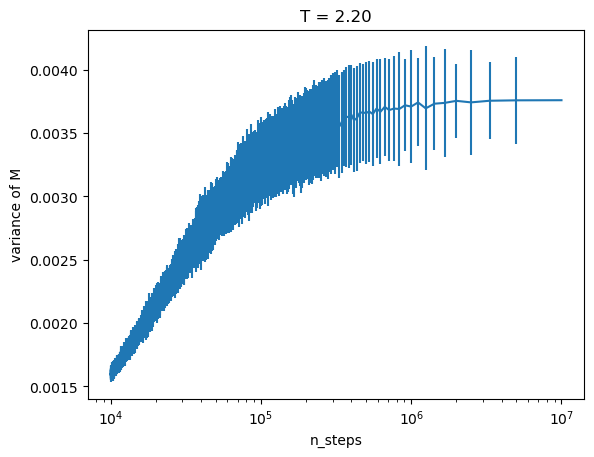

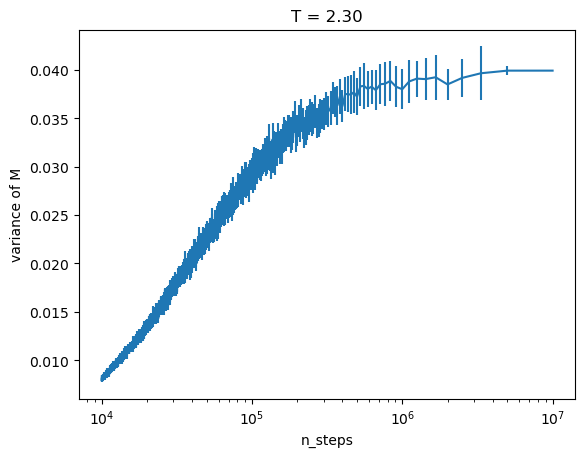

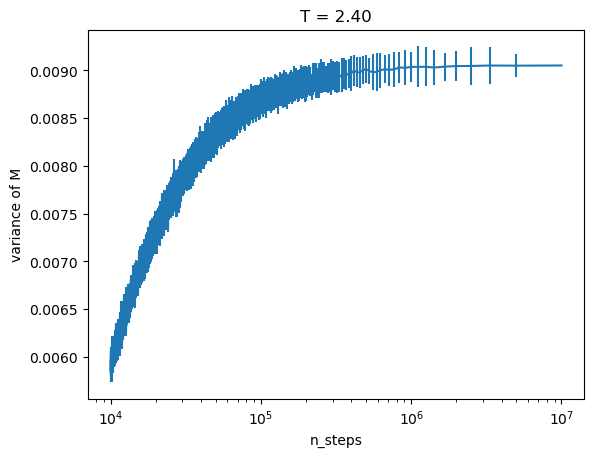

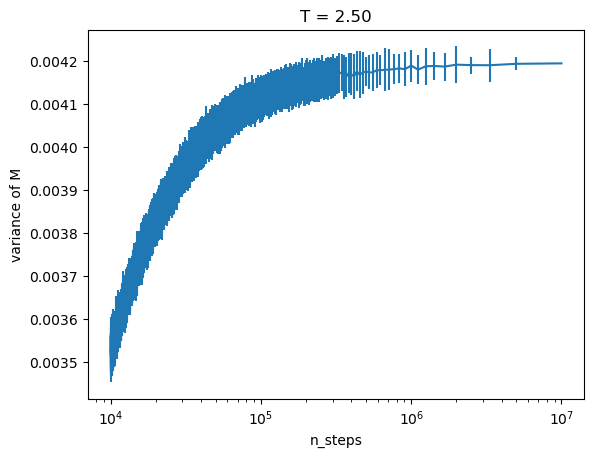

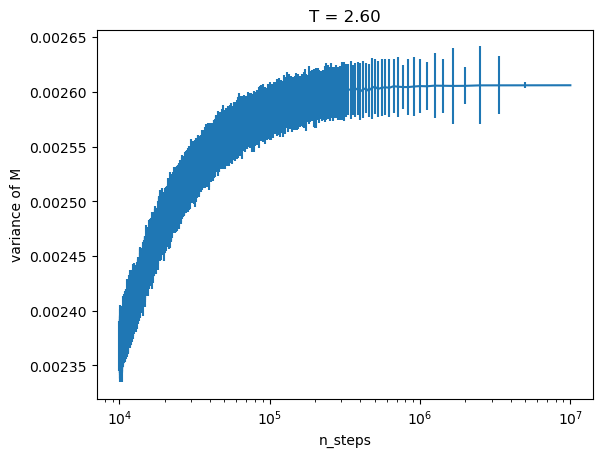

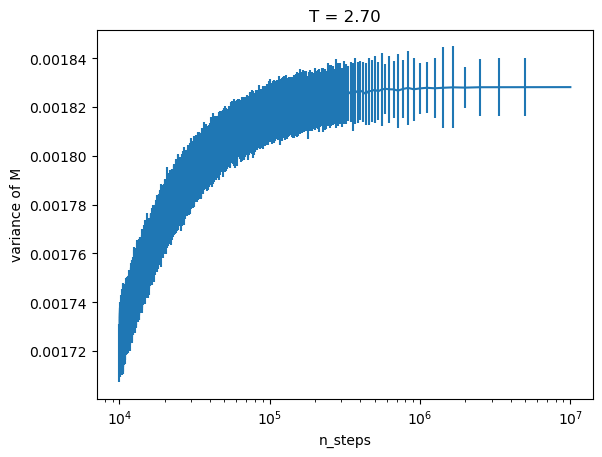

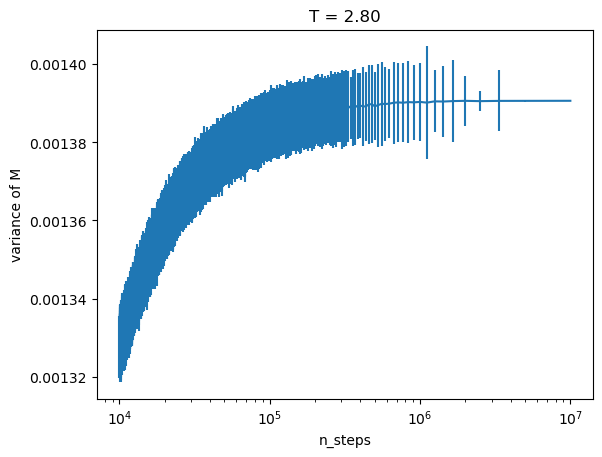

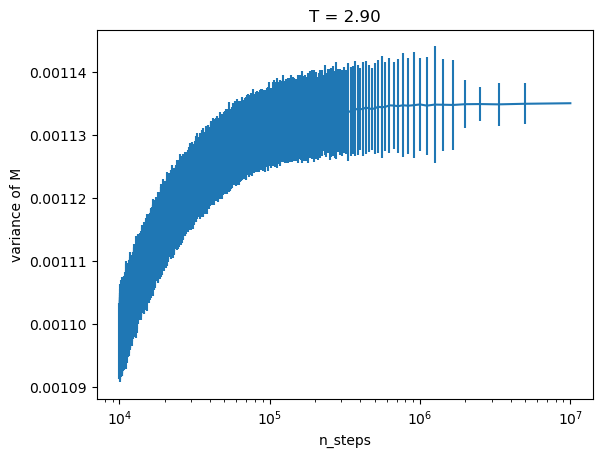

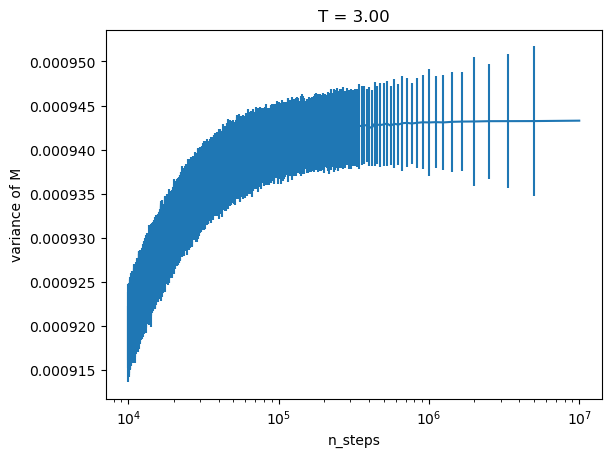

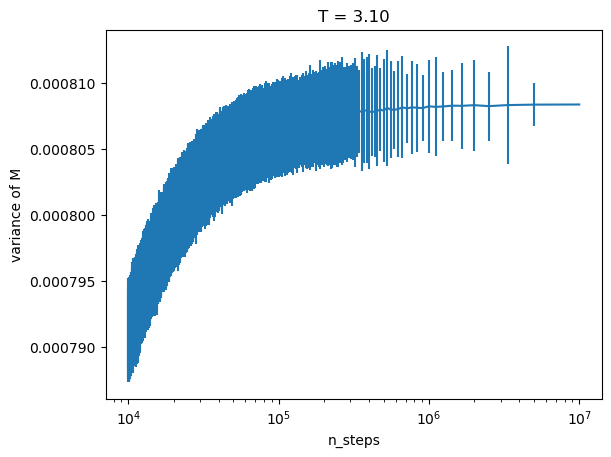

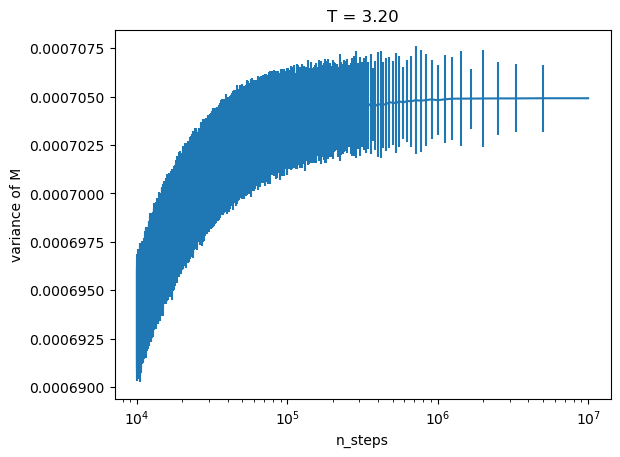

In [38]:
variances = []
e_variances = []
for idx, t in enumerate(temps):
    m_series = M[idx][n_burnin+n_slope:]
    n_split = range(1, 1000)
    chi_split = np.ndarray((1000))
    e_chi_split = np.ndarray((1000))
    for i in n_split:
        # split M series data into i equal pieces
        split_m = np.array_split(m_series, i)
        # calculate chi for each piece
        chi_split_vals = [np.var(x) for x in split_m] #can't do array op b/c split_m doesn't always have equal chunks
        # get average value of chi over all pieces
        chi_split[i] = np.average(chi_split_vals)
        # get standard error for chi over all pieces (assuming gaussian dist)
        e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
    variances.append(chi_split[1:])
    e_variances.append(e_chi_split[1:])
    plt.errorbar(n_analyze/np.array(range(1, 1000)), chi_split[1:], yerr=e_chi_split[1:])
    plt.xlabel("n_steps")
    plt.ylabel("variance of M")
    plt.xscale('log')
    plt.title(f"T = {t:.2f}")
    plt.show()

In [44]:
# to avoid calculating again
np_variances = np.array(variances)
np_e_variances = np.array(variances)
np.save("np_vars.npy", np_variances)
np.save("np_e_vars.npy", np_e_variances)

In [58]:
# piecewise into linear
def fit(x, m, y0, x0):
    # x is variable
    # m is slope in linear regime
    # y0 is final y value
    # x0 is x at which linear becomes flat
    return np.minimum((x-x0)*m + y0, y0)

In [47]:
from scipy.optimize import curve_fit

In [80]:
fits = np.ndarray((np_variances.shape[0], 3))
covs = np.ndarray((np_variances.shape[0], 3, 3))
xp = np.log10(n_analyze/np.array(range(1, 1000)))
for i in range(np_variances.shape[0]):
    fits[i], covs[i] = curve_fit(fit, xp, np_variances[i], p0=[.001, .003, 5], sigma=np_e_variances[i])

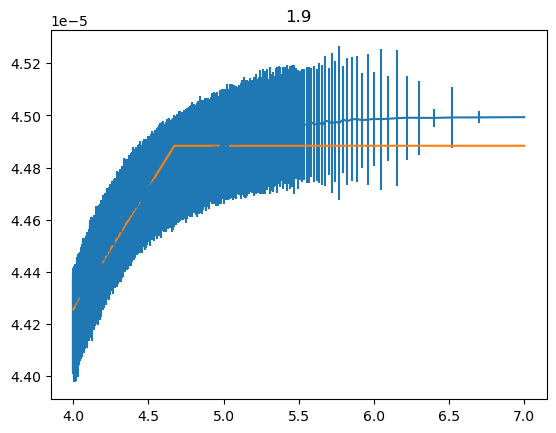

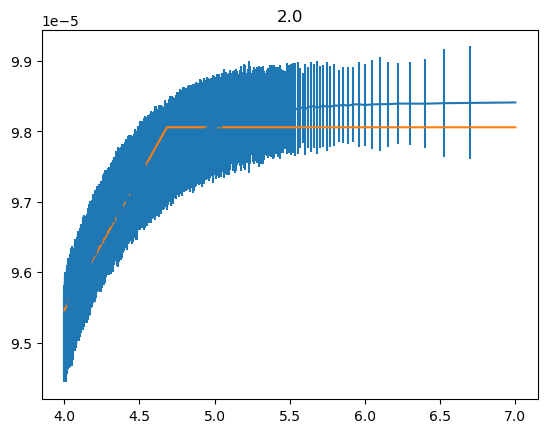

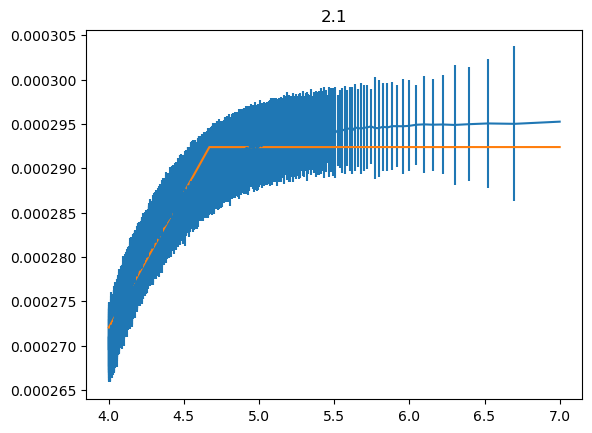

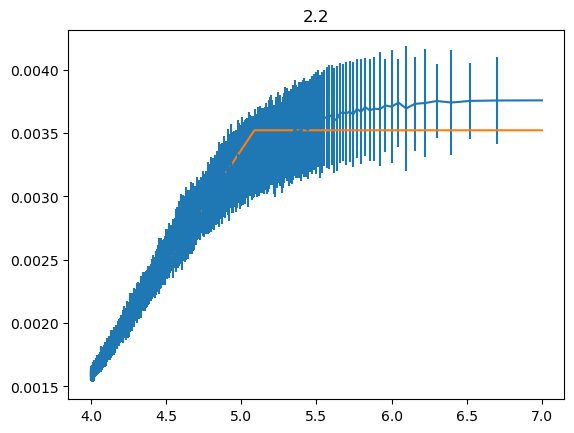

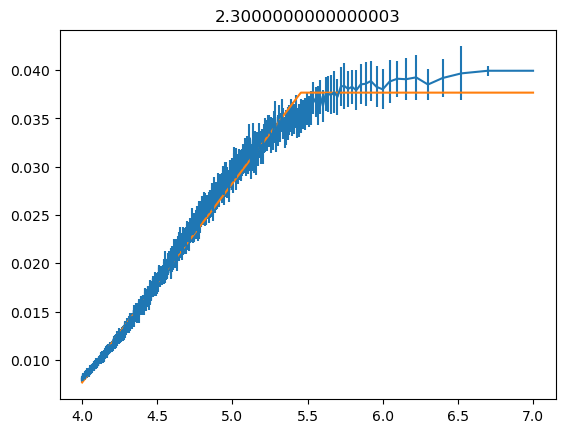

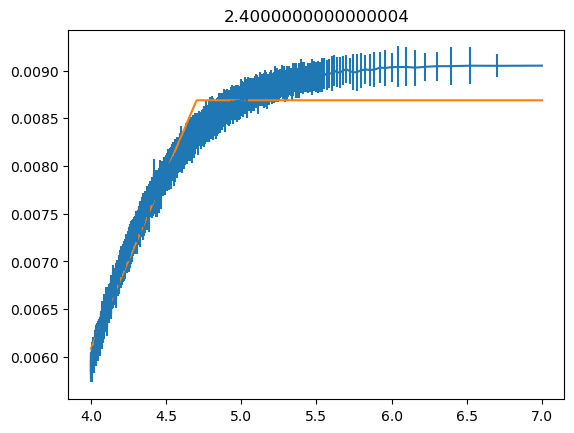

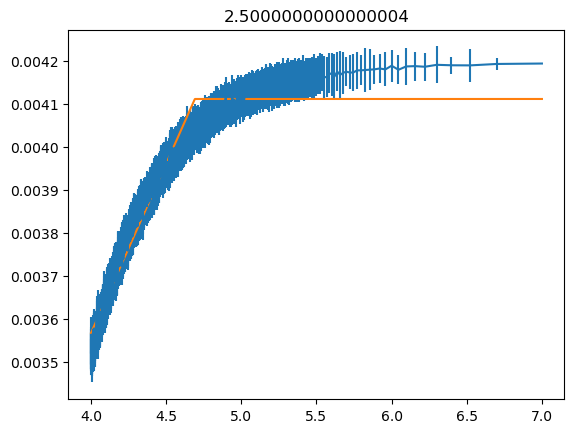

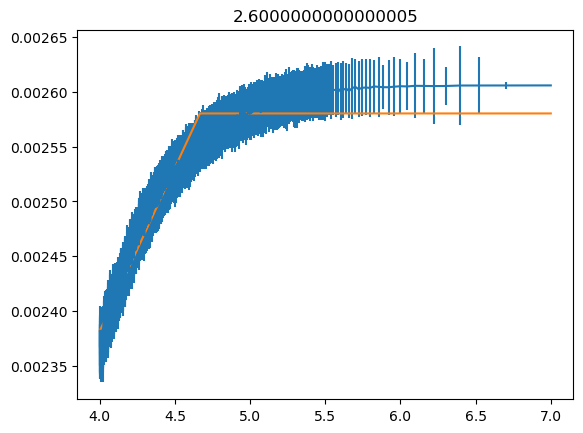

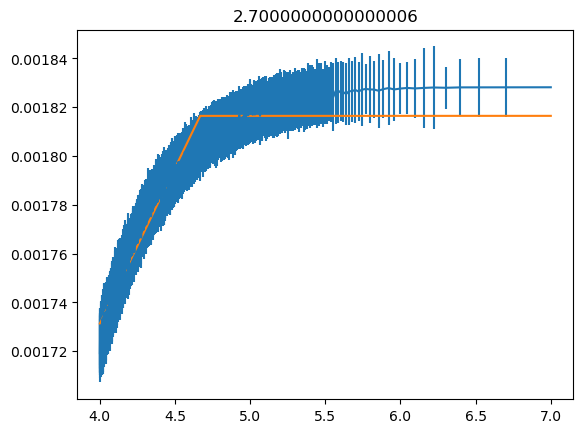

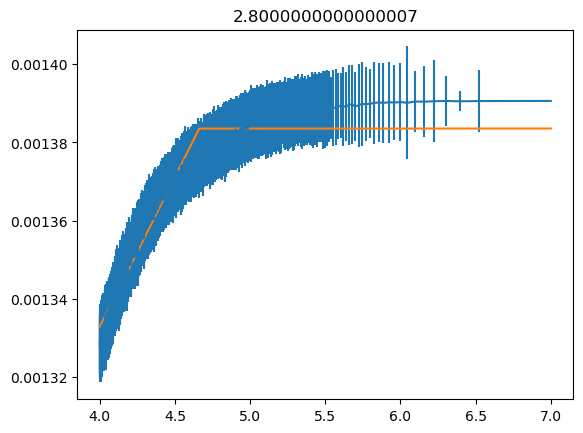

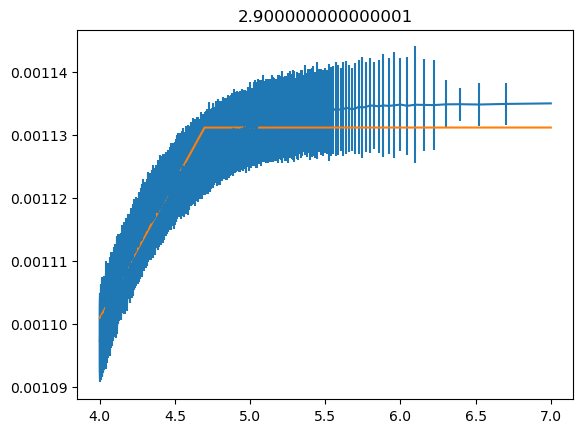

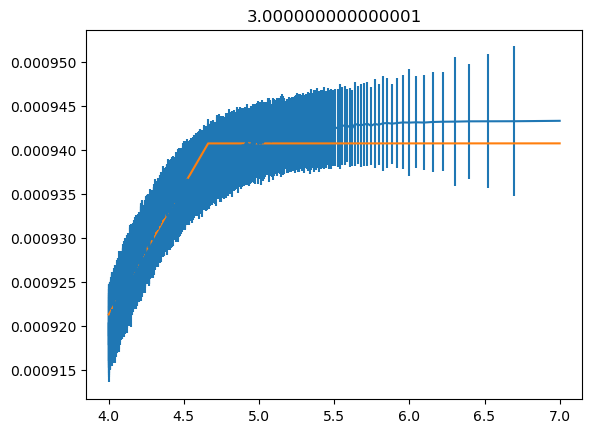

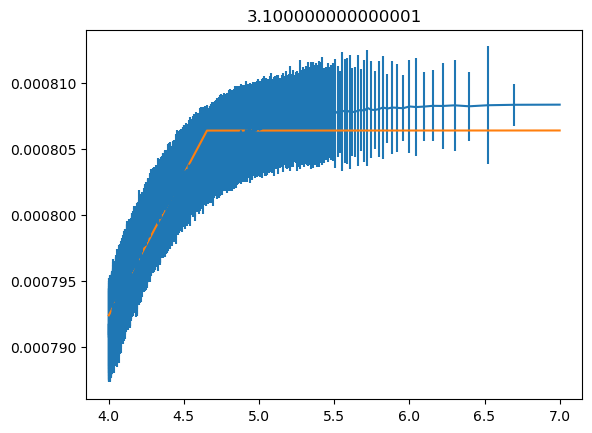

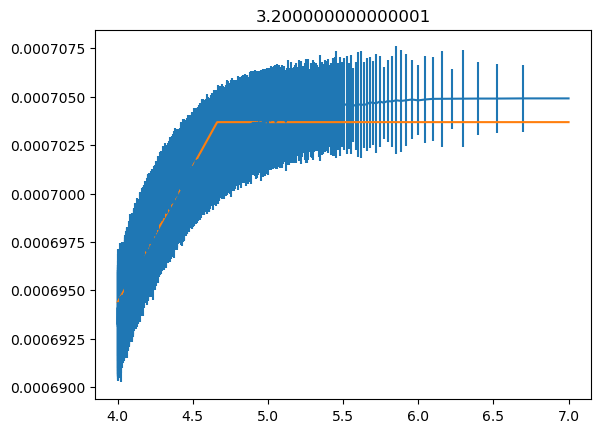

In [84]:
for i in range(np_variances.shape[0]):
    plt.errorbar(xp, np_variances[i], yerr=e_variances[i])
    plt.plot(xp, fit(xp, fits[i][0], fits[i][1], fits[i][2]))
    plt.title(temps[i])
    # plt.ylim(0, .05)
    plt.show()

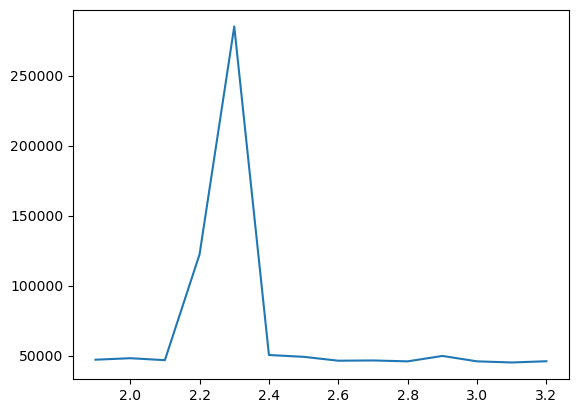

In [72]:
plt.plot(temps, 10**fits[:, 2])
# plt.ylim(0, 6)

(0.0, 0.05)

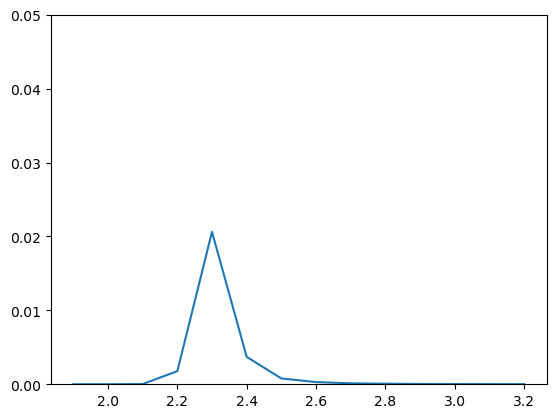

In [70]:
plt.plot(temps, fits[:, 0])
plt.ylim(0, .05)

In [92]:
# new fit function:
def expfit(x, a, y0, x0, m):
    return y0 - (a * np.exp(m*(x-x0)))

fits = np.ndarray((np_variances.shape[0], 4))
covs = np.ndarray((np_variances.shape[0], 4, 4))
xp = np.log10(n_analyze/np.array(range(1, 1000)))
for i in range(np_variances.shape[0]):
    fits[i], covs[i] = curve_fit(expfit, xp, np_variances[i], p0=[.001, .003, 5, -1], sigma=np_e_variances[i])

/tmp/ipykernel_35/3239454415.py:3: RuntimeWarning: overflow encountered in exp
  return y0 - (a * np.exp(m*(x-x0)))


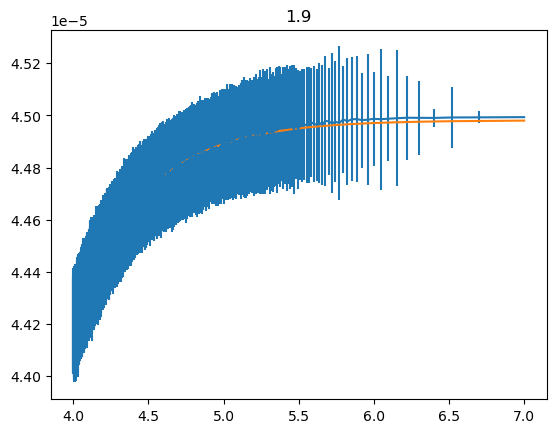

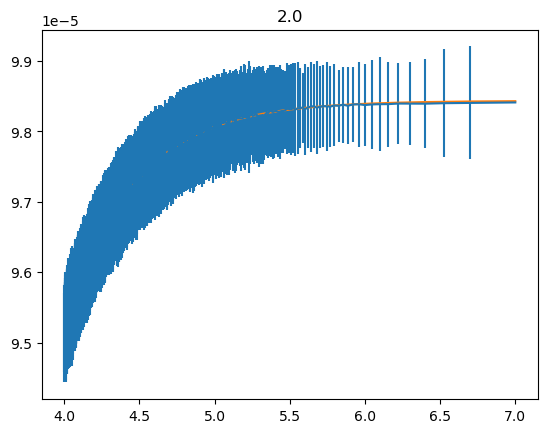

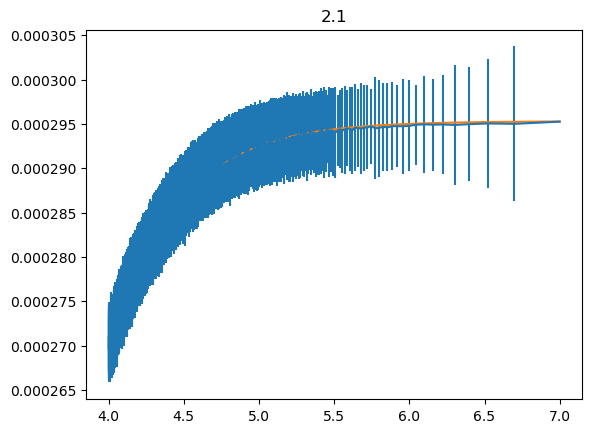

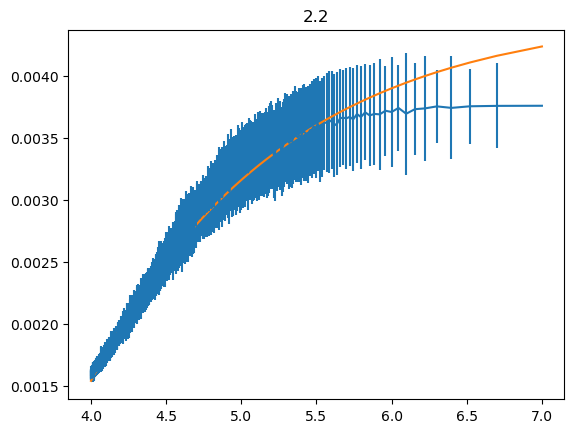

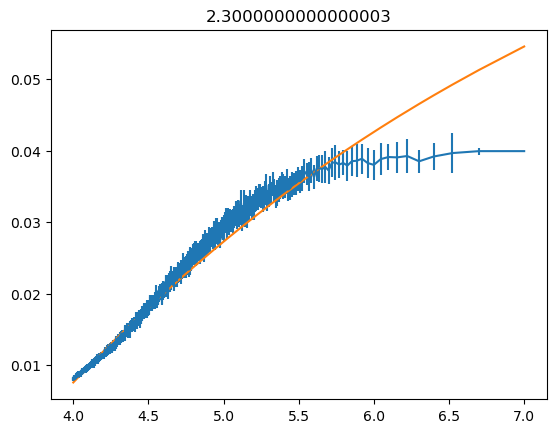

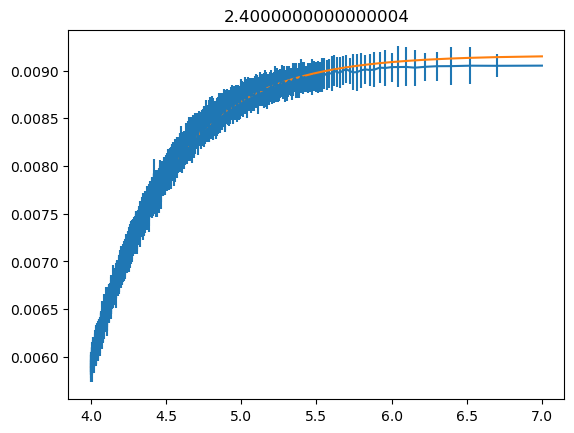

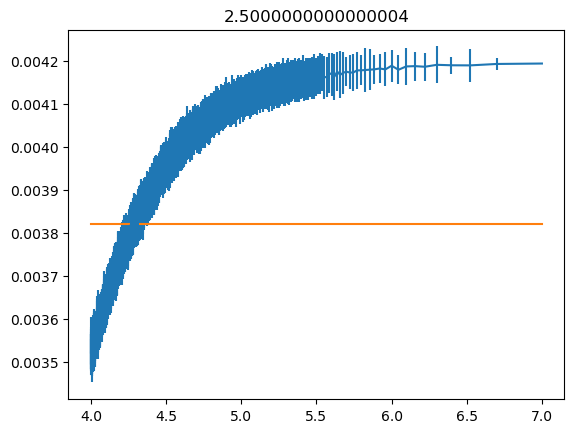

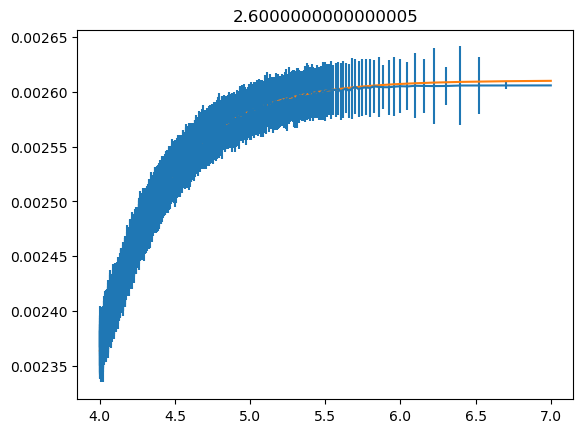

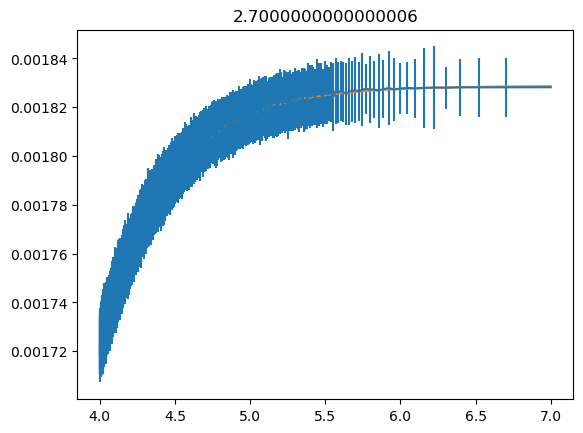

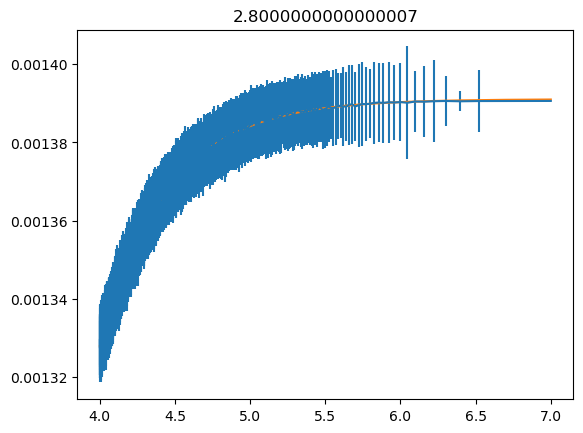

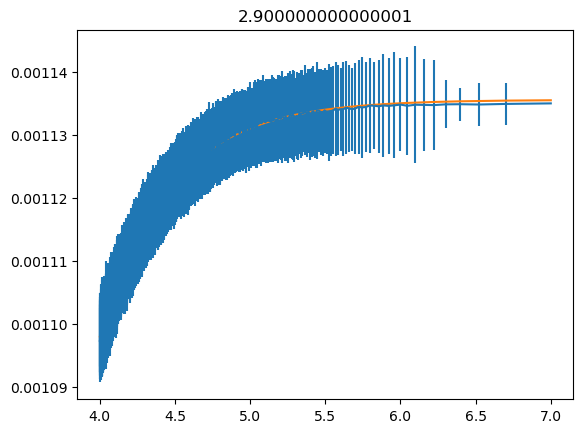

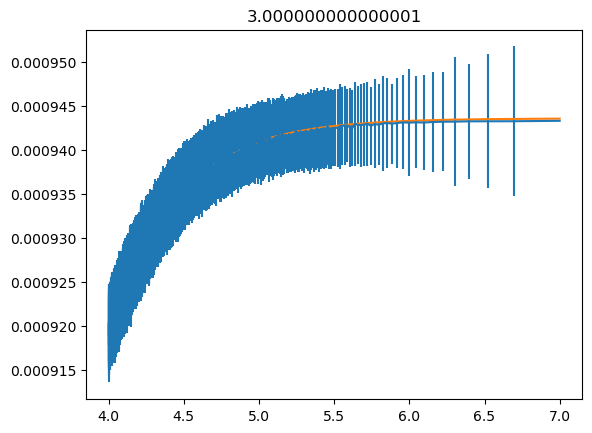

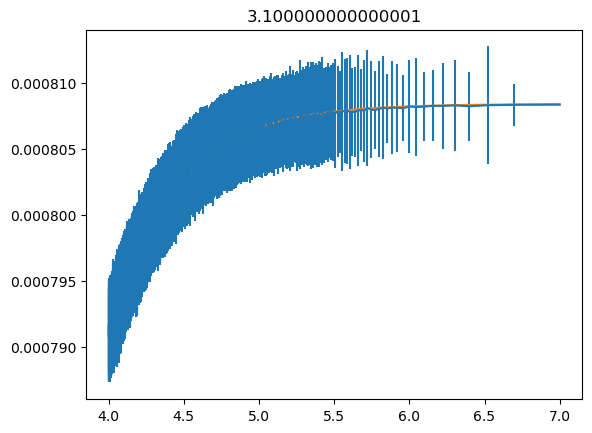

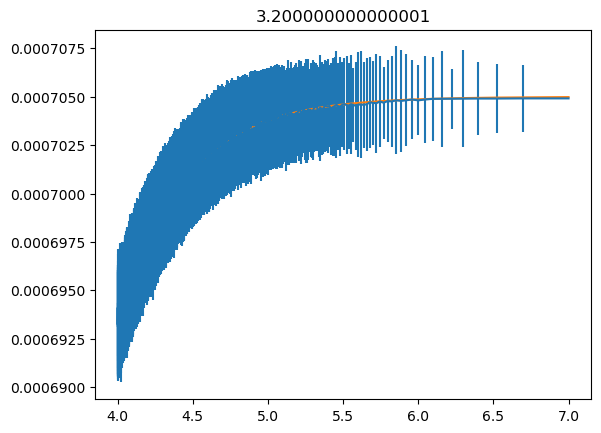

In [94]:
for i in range(np_variances.shape[0]):
    plt.errorbar(xp, np_variances[i], yerr=e_variances[i])
    plt.plot(xp, expfit(xp, fits[i][0], fits[i][1], fits[i][2], fits[i][3]))
    plt.title(temps[i])
    # plt.ylim(0, .05)
    plt.show()

In [1]:
# snorpshorps
experiment_name = "10M_Multitemp"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
low = np.load(f"datatests/{experiment_name}/snapshots/T1.9.npy")
med = np.load(f"datatests/{experiment_name}/snapshots/T2.3.npy")
hi = np.load(f"datatests/{experiment_name}/snapshots/T3.2.npy")

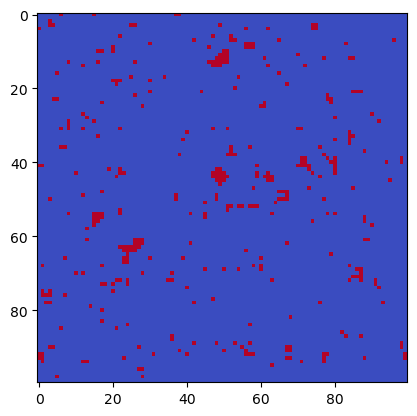

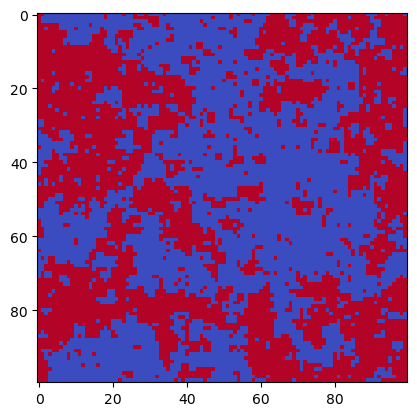

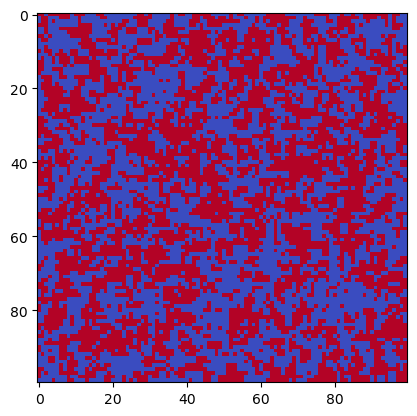

In [22]:
plt.imshow(-low, cmap="coolwarm")
plt.savefig("T = 1.9.svg", format='svg')
plt.show()
plt.imshow(-med, cmap="coolwarm")
plt.savefig("T = 2.3.svg", format='svg')
plt.show()
plt.imshow(-hi, cmap="coolwarm")
plt.savefig("T = 3.2.svg", format='svg')
plt.show()